In [29]:
from __future__ import absolute_import
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import numpy as np
import torch.nn
import torchvision
import glob
import os
import random
from PIL import Image
from torch.utils.data.dataset import Dataset

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [31]:
def validate_text_config(condition_config):
    assert 'text_condition_config' in condition_config, "Text conditioning desired but text condition config missing"
    assert 'text_embed_dim' in condition_config['text_condition_config'], "text_embed_dim missing in text condition config"

In [32]:
def load_latents(latent_path):
    latent_maps = {}
    for fname in glob.glob(os.path.join(latent_path, '*.pkl')):
        s = pickle.load(open(fname, 'rb'))
        for k, v in s.items():
            latent_maps[k] = v[0]
    return latent_maps

In [33]:
def drop_text_condition(text_embed, im, empty_text_embed, text_drop_prob):
    if text_drop_prob > 0:
        text_drop_mask = torch.zeros((im.shape[0]), device=im.device).float().uniform_(0,
                                                                                       1) < text_drop_prob
        assert empty_text_embed is not None, ("Text Conditioning required as well as text dropping but empty text representation not created")
        text_embed[text_drop_mask, :, :] = empty_text_embed[0]
    return text_embed


In [34]:
from transformers import DistilBertModel, DistilBertTokenizer, CLIPTokenizer, CLIPTextModel


def get_tokenizer_and_model(model_type, device, eval_mode=True):
    assert model_type in ('bert', 'clip'), "Text model can only be one of clip or bert"
    if model_type == 'bert':
        text_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        text_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
    else:
        text_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch16')
        text_model = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch16').to(device)
    if eval_mode:
        text_model.eval()
    return text_tokenizer, text_model
    

def get_text_representation(text, text_tokenizer, text_model, device,
                            truncation=True,
                            padding='max_length',
                            max_length=77):
    token_output = text_tokenizer(text,
                                  truncation=truncation,
                                  padding=padding,
                                  return_attention_mask=True,
                                  max_length=max_length)
    indexed_tokens = token_output['input_ids']
    att_masks = token_output['attention_mask']
    tokens_tensor = torch.tensor(indexed_tokens).to(device)
    mask_tensor = torch.tensor(att_masks).to(device)
    text_embed = text_model(tokens_tensor, attention_mask=mask_tensor).last_hidden_state
    return text_embed

### **Dataset**

In [35]:
# class CelebDataset(Dataset):
#     def __init__(self, split, im_path, im_size = 256, im_channels = 3, im_ext = 'jpg',
#                  use_latents = False, latent_path = None, condition_config = None):
#         self.split = split
#         self.im_size = im_size
#         self.im_channels = im_channels
#         self.im_ext = im_ext
#         self.im_path = im_path
#         self.latent_maps = None
#         self.use_latents = False

#         self.condition_types = [] if condition_config is None else condition_config['condition_types']
#         self.idx_to_cls_map = {}
#         self.cls_to_idx_map = {}

#         if 'image' in self.condition_types:
#             self.mask_channels = condition_config['image_condition_config']['image_condition_input_channels']
#             self.mask_h = condition_config['image_condition_config']['image_condition_h']
#             self.mask_w = condition_config['image_condition_config']['image_condition_w']

#         self.images, self.texts, self.masks = self.load_images(im_path)

#         if use_latents and latent_path is not None:
#             latent_maps = load_latents(latent_path)
#             if len(latent_maps) == len(self.images):
#                 self.use_latents = True
#                 self.latent_maps = latent_maps
#                 print('Found {} latents'.format(len(self.latent_maps)))
#             else:
#                 print('Latents not found')


#     def load_images(self, im_path):
#         assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
#         ims = []
#         fnames = glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('png')))
#         fnames += glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('jpg')))
#         fnames += glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('jpeg')))
#         texts = []
#         masks = []
#         if 'image' in self.condition_types:
#             label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth',
#                           'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']
#             self.idx_to_cls_map = {idx: label_list[idx] for idx in range(len(label_list))}
#             self.cls_to_idx_map = {label_list[idx]: idx for idx in range(len(label_list))}
#         for fname in tqdm(fnames):
#             ims.append(fname)

#             if 'text' in self.condition_types:
#                 im_name = os.path.split(fname)[1].split('.')[0]
#                 captions_im = []
#                 with open(os.path.join(im_path, 'celeba-caption/{}.txt'.format(im_name))) as f:
#                     for line in f.readlines():
#                         captions_im.append(line.strip())
#                 texts.append(captions_im)

#             if 'image' in self.condition_types:
#                 im_name = int(os.path.split(fname)[1].split('.')[0])
#                 masks.append(os.path.join(im_path, 'CelebAMask-HQ-mask', '{}.png'.format(im_name)))
#         if 'text' in self.condition_types:
#             assert len(texts) == len(ims), "Condition Type Text but could not find captions for all images"
#         if 'image' in self.condition_types:
#             assert len(masks) == len(ims), "Condition Type Image but could not find masks for all images"
#         print('Found {} images'.format(len(ims)))
#         print('Found {} masks'.format(len(masks)))
#         print('Found {} captions'.format(len(texts)))
#         return ims, texts, masks

#     def get_mask(self, index):
#         mask_im = Image.open(self.masks[index])
#         mask_im = np.array(mask_im)
#         im_base = np.zeros((self.mask_h, self.mask_w, self.mask_channels))
#         for orig_idx in range(len(self.idx_to_cls_map)):
#             im_base[mask_im == (orig_idx+1), orig_idx] = 1
#         mask = torch.from_numpy(im_base).permute(2, 0, 1).float()
#         return mask
#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         cond_inputs = {}
#         if 'text' in self.condition_types:
#             cond_inputs['text'] = random.sample(self.texts[index], k=1)[0]
#         if 'image' in self.condition_types:
#             mask = self.get_mask(index)
#             cond_inputs['image'] = mask
#             if self.use_latents:
#                 latent = self.latent_maps[self.images[index]]
#             if len(self.condition_types) == 0:
#                 return latent
#             else:
#                 return latent, cond_inputs
#         else:
#             im = Image.open(self.images[index])
#             im_tensor = torchvision.transforms.Compose([
#                 torchvision.transforms.Resize(self.im_size),
#                 torchvision.transforms.CenterCrop(self.im_size),
#                 torchvision.transforms.ToTensor(),
#             ])(im)
#             im.close()
#             im_tensor = (2 * im_tensor) - 1
#             if len(self.condition_types) == 0:
#                 return im_tensor
#             else:
#                 return im_tensor, cond_inputs

### **# Blocks**

In [36]:
def get_time_embedding(time_steps, temb_dim):
    assert temb_dim % 2 == 0, 'time embedding dimension must be divisible by 2'
    factor = 10000 ** ((torch.arange(
        start = 0, end = temb_dim // 2, dtype = torch.float32, device = time_steps.device) / (temb_dim // 2))
    )
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim = -1)
    return t_emb

In [37]:
class DownBlock(nn.Module):

    def __init__(self, in_channels, out_channels, t_emb_dim, down_sample, num_heads, num_layers, attn, norm_channels, cross_attn = False, context_dim = None):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.attn = attn
        self.context_dim = context_dim
        self.cross_attn = cross_attn
        self.t_emb_dim = t_emb_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
                )
                for i in range(num_layers)
            ]
        )
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(self.t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
                )
                for _ in range(num_layers)
            ]
        )
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                for _ in range(num_layers)]
            )
            self.attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
                for _ in range(num_layers)]
            )
        if self.cross_attn:
            assert context_dim is not None, "Context dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
                for _ in range(num_layers)]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels)
                for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size = 1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, 4, 2, 1) if self.down_sample else nn.Identity()

    def forward(self, x, t_emb = None, context = None):
        out = x
#         print(out.size())
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            if self.attn:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn , in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn

            if self.cross_attn:
                assert context is not None, "context cannot be none if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        out = self.down_sample_conv(out)
        return out



In [38]:
class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads, num_layers, norm_channels, cross_attn = None, context_dim = None):
        super().__init__()
        self.num_layers = num_layers
        self.t_emb_dim = t_emb_dim
        self.context_dim = context_dim
        self.cross_attn = cross_attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                )
                for i in range(num_layers + 1)
            ]
        )
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers + 1)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers + 1)
            ]
        )
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(norm_channels, out_channels)
            for _ in range(num_layers)]
        )
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
            for _ in range(num_layers)]
        )
        if self.cross_attn:
            assert context_dim is not None, "Context dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
                for _ in range(num_layers)]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels)
                for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size = 1)
                for i in range(num_layers + 1)
            ]
        )

    def forward(self, x, t_emb = None, context = None):
        out = x
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        if self.t_emb_dim is not None:
            out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)

        for i in range(self.num_layers):
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

            if self.cross_attn:
                assert context is not None, "context cannot be none if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn

            resnet_input = out
            out = self.resnet_conv_first[i + 1](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i + 1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i + 1](out)
            out = out + self.residual_input_conv[i + 1](resnet_input)

        return out



In [39]:
class UpBlock(nn.Module):

    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample, num_heads, num_layers, attn, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.attn = attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
                )
                for i in range(num_layers)
            ]
        )
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(norm_channels, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
            )
            for _ in range(num_layers)
        ])
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                for _ in range(num_layers)]
            )
            self.attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
                for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size = 1)
            for i in range(num_layers)]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1) if self.up_sample else nn.Identity()

    def forward(self, x, out_down = None, t_emb = None):
        x = self.up_sample_conv(x)
        if out_down is not None:
            x = torch.cat([x, out_down], dim = 1)
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            if self.attn:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.tranpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        return out



In [40]:
class UpBlockUnet(nn.Module):

    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample, num_heads, num_layers, norm_channels,
                    cross_attn = False, context_dim = None):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.cross_attn = cross_attn
        self.context_dim = context_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                )
                for i in range(num_layers)
            ]
        )
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])

        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
#         if self.attn:
#             self.attention_norms = nn.ModuleList(
#                 [
#                     nn.GroupNorm(norm_channels, out_channels)
#                     for _ in range(num_layers)
#                 ]
#             )

#             self.attentions = nn.ModuleList(
#                 [
#                     nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
#                     for _ in range(num_layers)
#                 ]
#             )

#         if self.cross_attn:
#             assert context_dim is not None, "Context Dimension must be passed for cross attention"
#             self.cross_attention_norms = nn.ModuleList(
#                 [nn.GroupNorm(norm_channels, out_channels)
#                 for _ in range(num_layers)]
#             )
#             self.cross_attentions = nn.ModuleList(
#                 [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
#                 for _ in range(num_layers)]
#             )
#             self.context_proj = nn.ModuleList(
#                 [nn.Linear(context_dim, out_channels)
#                 for _ in range(num_layers)]
#             )
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(norm_channels, out_channels)
                for _ in range(num_layers)
            ]
        )
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
                for _ in range(num_layers)
            ]
        )
        
        if self.cross_attn:
            assert context_dim is not None, "Context dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [
                    nn.GroupNorm(norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )
            self.cross_attentions = nn.ModuleList(
                [
                    nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
                    for _ in range(num_layers)
                ]
            )
            self.context_proj = nn.ModuleList(
                [
                    nn.Linear(context_dim, out_channels)
                    for _ in range(num_layers)
                ]
            )
            
        self.residual_input_conv = nn.ModuleList(
            [nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
            for i in range(num_layers)]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, 4, 2, 1) if self.up_sample else nn.Identity()

    def forward(self, x, out_down=None, t_emb=None, context=None):
        x = self.up_sample_conv(x)
        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)

        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

            if self.cross_attn:
                assert context is not None, "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert len(context.shape) == 3, "Context shape does not match B,_,CONTEXT_DIM"
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim,"Context shape does not match B,_,CONTEXT_DIM"
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn

        return out

### **UNET**

In [41]:
# class Unet(nn.Module):
#     def __init__(self, im_channels, model_config):
#         super().__init__()
#         self.down_channels = model_config['down_channels']
#         self.mid_channels = model_config['mid_channels']
#         self.t_emb_dim = model_config['time_emb_dim']
#         self.down_sample = model_config['down_sample']
#         self.num_down_layers = model_config['num_down_layers']
#         self.num_mid_layers = model_config['num_mid_layers']
#         self.num_up_layers = model_config['num_up_layers']
#         self.attns = model_config['attn_down']
#         self.norm_channels = model_config['norm_channels']
#         self.num_heads = model_config['num_heads']
#         self.conv_out_channels = model_config['conv_out_channels']

#         assert self.mid_channels[0] == self.down_channels[-1]
#         assert self.mid_channels[-1] == self.down_channels[-2]
#         assert len(self.down_sample) == len(self.down_channels) - 1
#         assert len(self.attns) == len(self.down_channels) - 1

#         self.text_cond = False
#         self.text_embed_dim = None
#         self.condition_config = get_config_value(model_config, 'condition_config', None)
        
#         self.t_proj = nn.Sequential(
#             nn.Linear(self.t_emb_dim, self.t_emb_dim),
#             nn.SiLU(),
#             nn.Linear(self.t_emb_dim, self.t_emb_dim)
#         )
#         self.up_sample = list(reversed(self.down_sample))
#         self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=1)
#         self.downs = nn.ModuleList([])
#         for i in range(len(self.down_channels) - 1):
#             self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i + 1], self.t_emb_dim,
#                                         down_sample = self.down_sample[i], nums_head = self.nums_head,
#                                         num_layers = self.num_down_layers,
#                                         attn = self.attns[i], norm_channels = self.norm_channels))
#         self.mids = nn.ModuleList([])
#         for i in range(len(self.mid_channels) - 1):
#             self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1], self.t_emb_dim,
#                                         num_heads = self.num_heads, num_layers = self.num_mid_layers,
#                                         norm_channels = self.norm_channels))
#         self.ups = nn.ModuleList([])
#         for i in reversed(range(len(self.down_channels) - 1)):
#             self.ups.append(UpBlockUnet(self.down_channels[i] * 2, self.down_channels[i - 1] if i != 0 else self.conv_out_channels,
#                                         self.t_emb_dim, up_sample = self.down_sample[i], num_heads = self.num_heads,
#                                         num_layers = self.num_layers, norm_channels = self.norm_channels))
#         self.norm_out = nn.GroupNorm(self.norm_channels, self.conv_out_channels)
#         self.conv_out = nn.Conv2d(self.conv_out_channels, im_channels, kernel_size = 3, padding = 1)

#     def forward(self, x, t):
#         out = self.conv_in(x)
#         t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
#         t_emb = self.t_proj(t_emb)
#         down_outs = []
#         for idx, down in enumerate(self.downs):
#             down_outs.append(out)
#             out = down(out, t_emb)
#         for mid in self.mids:
#             out = mid(out, t_emb)
#         for up in self.ups:
#             down_out = down_outs.pop()
#             out = up(out, down_out, t_emb)
#         out = self.norm_out(out)
#         out = nn.SiLU()(out)
#         return out

In [42]:
class Unet(nn.Module):
    def __init__(self, im_channels, model_config):
        super().__init__()
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        self.attns = model_config['attn_down']
        self.norm_channels = model_config['norm_channels']
        self.num_heads = model_config['num_heads']
        self.conv_out_channels = model_config['conv_out_channels']

        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1
        assert len(self.attns) == len(self.down_channels) - 1

        self.text_cond = False
        self.text_embed_dim = None
        self.condition_config = get_config_value(model_config, 'condition_config', None)
        
        if self.condition_config is not None:
            assert 'condition_types' in self.condition_config, 'Condition type not porvided in condition config'
            condition_types = self.condition_config['condition_types']
            if 'text' in condition_types:
                validate_text_config(self.condition_config)
                self.text_cond = True
                self.text_embed_dim = self.condition_config['text_condition_config']['text_embed_dim']
        
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size = 3, padding = 1)
        self.cond = self.text_cond
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        
        self.up_sample = list(reversed(self.down_sample))
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i + 1], self.t_emb_dim,
                                        down_sample=self.down_sample[i],
                                        num_heads=self.num_heads,
                                        num_layers=self.num_down_layers,
                                        attn=self.attns[i], norm_channels=self.norm_channels,
                                        cross_attn=self.text_cond,
                                        context_dim=self.text_embed_dim))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1], self.t_emb_dim,
                                      num_heads=self.num_heads,
                                      num_layers=self.num_mid_layers,
                                      norm_channels=self.norm_channels,
                                      cross_attn=self.text_cond,
                                      context_dim=self.text_embed_dim))
                
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels) - 1)):
            self.ups.append(
                UpBlockUnet(self.down_channels[i] * 2, self.down_channels[i - 1] if i != 0 else self.conv_out_channels,
                            self.t_emb_dim, up_sample=self.down_sample[i],
                            num_heads=self.num_heads,
                            num_layers=self.num_up_layers,
                            norm_channels=self.norm_channels,
                            cross_attn=self.text_cond,
                            context_dim=self.text_embed_dim))
        
        self.norm_out = nn.GroupNorm(self.norm_channels, self.conv_out_channels)
        self.conv_out = nn.Conv2d(self.conv_out_channels, im_channels, kernel_size=3, padding=1)
    
    def forward(self, x, t, cond_input = None):
        if self.cond:
            assert cond_input is not None, 'Model initialised with conditioning so cond_input cannot be none'
        
        out = self.conv_in(x)
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        context_hidden_states = None
        if self.text_cond:
            assert 'text' in cond_input, 'Model initialised with text conditioning but cond_input has no text information'
            context_hidden_states= cond_input['text']
        
        down_outs = []
        
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb, context_hidden_states)
        
        for mid in self.mids:
            out = mid(out, t_emb, context_hidden_states)
        
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb, context_hidden_states)
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        return out

### **LPIPS**

In [43]:
from __future__ import absolute_import
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import numpy as np
import torch.nn
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
def spatial_average(in_tens, keepdim = True):
    return in_tens.mean([2, 3], keepdim = keepdim)

In [45]:
class vgg16(torch.nn.Module):
    def __init__(self, requires_grad = False, pretrained = True):
        super(vgg16, self).__init__()
        vgg_pretrained_features = torchvision.models.vgg16(pretrained = pretrained).features
        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        self.slice5 = nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])

        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)
        return out



In [46]:
class LPIPS(nn.Module):
    def __init__(self, net = 'vgg', version = '0.1', use_dropout = True):
        super(LPIPS, self).__init__()
        self.version = version
        self.scaling_layer = ScalingLayer()

        self.chns = [64, 128, 256, 512, 512]
        self.L =  len(self.chns)
        self.net = vgg16(pretrained = True, requires_grad = False)

        self.lin0 = NetLinLayer(self.chns[0], use_dropout = use_dropout)
        self.lin1 = NetLinLayer(self.chns[1], use_dropout = use_dropout)
        self.lin2 = NetLinLayer(self.chns[2], use_dropout = use_dropout)
        self.lin3 = NetLinLayer(self.chns[3], use_dropout = use_dropout)
        self.lin4 = NetLinLayer(self.chns[4], use_dropout = use_dropout)
        self.lins = [self.lin0, self.lin1, self.lin2, self.lin3, self.lin4]
        self.lins = nn.ModuleList(self.lins)

        import inspect
        import os

#         model_path = os.path.abspath(
#             os.path.join(inspect.getfile(self.__init__), '..', 'weights/v%s/%s.pth' % (version, net)))
        model_path = '/root/.cache/torch/hub/checkpoints/vgg16-397923af.pth'
        print('Loading model from: %s' % model_path)
        self.load_state_dict(torch.load(model_path, map_location=device), strict=False)

        self.eval()
        for param in self.parameters():
            param.requires_grad = False


    def forward(self, in0, in1, normalize = False):
        if normalize:
            in0 = 2 * in0 - 1
            in1 = 2 * in1 - 1

        in0_input, in1_input = self.scaling_layer(in0), self.scaling_layer(in1)

        outs0, outs1 = self.net.forward(in0_input), self.net.forward(in1_input)
        feats0, feats1, diffs = {}, {}, {}

        for kk in range(self.L):
            feats0[kk], feats1[kk] = nn.functional.normalize(outs0[kk], dim = 1), nn.functional.normalize(outs1[kk])
            diffs[kk] = (feats0[kk] - feats1[kk]) ** 2

        res = [spatial_average(self.lins[kk](diffs[kk]), keepdim = True) for kk in range(self.L)]
        val = 0

        for l in range(self.L):
            val += res[l]
        return val




In [47]:
class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer('shift', torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer('scale', torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, inp):
        return (inp - self.shift) / self.scale


In [48]:
class NetLinLayer(nn.Module):
    def __init__(self, chn_in, chn_out = 1, use_dropout = False):
        super(NetLinLayer, self).__init__()

        layers = [nn.Dropout(), ] if (use_dropout) else []
        layers += [nn.Conv2d(chn_in, chn_out, 1, stride = 1, padding = 0, bias = False), ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

### **Discriminator**

In [49]:
class Discriminator(nn.Module):
    def __init__(self, im_channels = 3, conv_channels = [64, 128, 256], kernels = [4, 4, 4, 4],
                 strides = [2, 2, 2, 1], padding = [1, 1, 1, 1]):
        super().__init__()
        self.im_channels = im_channels
        activation = nn.LeakyReLU(0.2)
        layers_dim = [self.im_channels] + conv_channels + [1]
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(layers_dim[i], layers_dim[i + 1], kernel_size = kernels[i], stride = strides[i], padding = padding[i], bias = False if (i != 0) else True),
                nn.BatchNorm2d(layers_dim[i + 1]) if i!= len(layers_dim) - 2 and i != 0 else nn.Identity(), activation if i != len(layers_dim) - 2 else nn.Identity())
            for i in range(len(layers_dim) - 1)
        ])

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
            return out

In [50]:
if __name__ == '__main__':
    x = torch.randn((2,3, 256, 256))
    prob = Discriminator(im_channels=3)(x)
    print(prob.shape)

torch.Size([2, 64, 128, 128])


### **VQVAE**

In [51]:
class VQVAE(nn.Module):
    def __init__(self, im_channels, model_config):
        super().__init__()
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        self.norm_channels = model_config['norm_channels']

        self.attns = model_config['attn_down']
        self.num_heads = model_config['num_heads']

        self.z_channels = model_config['z_channels']
        self.codebook_size = model_config['codebook_size']
        
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-1]
        assert len(self.down_sample) == len(self.down_channels) - 1
        assert len(self.attns) == len(self.down_channels) - 1
        
        
        self.up_sample = list(reversed(self.down_sample))

        self.encoder_conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size = 3, padding = (1, 1))

        self.encoder_downs = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.encoder_downs.append(DownBlock(self.down_channels[i], self.down_channels[i + 1],
                                                t_emb_dim = None, down_sample = self.down_sample[i],
                                                num_heads = self.num_heads, num_layers = self.num_down_layers,
                                                attn = self.attns[i], norm_channels = self.norm_channels))
        self.encoder_mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.encoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1],
                                                t_emb_dim = None, num_heads = self.num_heads,
                                                num_layers = self.num_mid_layers, norm_channels = self.norm_channels))
        self.encoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[-1])
        self.encoder_conv_out = nn.Conv2d(self.down_channels[-1], self.z_channels, kernel_size = 3, padding = 1)

        self.pre_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size = 1)

        self.embedding = nn.Embedding(self.codebook_size, self.z_channels)

        self.post_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size = 1)
        self.decoder_conv_in = nn.Conv2d(self.z_channels, self.mid_channels[-1], kernel_size = 3, padding = (1, 1))

        self.decoder_mids = nn.ModuleList([])
        for i in reversed(range(1, len(self.mid_channels))):
            self.decoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i - 1], t_emb_dim = None,
                                              num_heads = self.num_heads, num_layers = self.num_mid_layers,
                                              norm_channels = self.norm_channels))
        self.decoder_ups = nn.ModuleList([])
        for i in reversed(range(1, len(self.down_channels))):
            self.decoder_ups.append(UpBlock(self.down_channels[i], self.down_channels[i - 1], t_emb_dim = None,
                                            up_sample = self.down_sample[i - 1], num_heads = self.num_heads,
                                            num_layers = self.num_up_layers, attn = self.attns[i - 1],
                                            norm_channels = self.norm_channels))

        self.decoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[0])
        self.decoder_conv_out = nn.Conv2d(self.down_channels[0], im_channels, kernel_size = 3, padding = (1, 1))

    def quantize(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(x.size(0), -1, x.size(-1))

        dist = torch.cdist(x, self.embedding.weight[None, :].repeat((x.size(0), 1, 1)))
        min_encoding_indices = torch.argmin(dist, dim = -1)

        quant_out = torch.index_select(self.embedding.weight,0, min_encoding_indices.view(-1))

        x = x.reshape((-1, x.size(-1)))
        commitment_loss = torch.mean((quant_out.detach() - x) ** 2)
        codebook_loss = torch.mean((quant_out - x.detach()) ** 2)
        quantize_losses = {
            'codebook_loss': codebook_loss,
            'commitment_loss': commitment_loss,
        }
        quant_out = x + (quant_out - x).detach()

        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))

        return quant_out, quantize_losses
    def encode(self, x):
        out = self.encoder_conv_in(x)
        for idx, down in enumerate(self.encoder_downs):
            out = down(out)
        for mid in self.encoder_mids:
            out = mid(out)
        out = self.encoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.encoder_conv_out(out)
        out = self.pre_quant_conv(out)
        out, quant_losses = self.quantize(out)
        return out, quant_losses

    def decode(self, z):
        out = z
        out = self.post_quant_conv(out)
        out = self.decoder_conv_in(out)
        for mid in self.decoder_mids:
            out = mid(out)
        for idx, up in enumerate(self.decoder_ups):
            out = up(out)
        out = self.decoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.decoder_conv_out(out)
        return out

    def forward(self, x):
        z, quant_losses = self.encode(x)
        out = self.decode(z)
        return out, z, quant_losses

### **Linear Noise Scheduler**

In [52]:
class LinearNoiseScheduler:
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim = 0).to(device)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod).to(device)
        self.one_minus_alpha_cum_prod = torch.sqrt(1. - self.alpha_cum_prod).to(device)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod).to(device)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise

    def sample_prev_timestep(self, xt, noise_pred, t):
        x0 = (xt - (self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)) / self.sqrt_alpha_cum_prod[t]
        x0 = torch.clamp(x0, -1., 1.)
        mean = xt - ((self.betas[t] * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod[t]))
        mean = mean / torch.sqrt(self.alphas[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod[t - 1]) / (1. - self.alpha_cum_prod[t])
            variance = variance * self.betas[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

### **Train VQVAE**

In [53]:
import yaml
import argparse
import random
import torchvision
import os
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [54]:
from torch.utils.data.dataloader import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as F

In [ ]:
os.mkdir('weights')
directory = 'v0.1'
path = os.path.join('/kaggle/working/weights', directory)
os.mkdir(path)

In [55]:
image_list = []
for filename in glob.glob('/kaggle/input/celebritydataset/celeba_hq_256/*.jpg'): #assuming jpg 
    im = Image.open(filename) 
    image_list.append(im) 

In [56]:
print(image_list[0].size)

(256, 256)


In [57]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, augmentations):
        super(MyDataset, self).__init__()
        self.img_list = img_list
        self.augmentations = augmentations

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
        return self.augmentations(img)
  


In [58]:
# Creating a custom dataset class 
class ImageDataset(torch.utils.data.Dataset): 
    def __init__(self, img_list, transform): 
        self.img_list = img_list
        self.transform = transform 
        self.counter = 0
  
    # Defining the length of the dataset 
    def __len__(self): 
        return len(self.img_list) 
  
    # Defining the method to get an item from the dataset 
    def __getitem__(self, index): 
        image = self.img_list[index]
        image = self.transform(image) 
          
        return image

In [59]:
# Creating a custom dataset class 
class ImageDataset(torch.utils.data.Dataset): 
    def __init__(self, img_list, transform): 
        self.img_list = img_list
        self.transform = transform 
        self.counter = 0
        self.condition_types = ['text']
  
    # Defining the length of the dataset 
    def __len__(self): 
        return len(self.img_list) 
  
    # Defining the method to get an item from the dataset 
    def __getitem__(self, index): 
        image = self.img_list[index]
        image = self.transform(image) 
          
        return image

In [60]:
class CelebDataset(Dataset):
    r"""
    Celeb dataset will by default centre crop and resize the images.
    This can be replaced by any other dataset. As long as all the images
    are under one directory.
    """
    
    def __init__(self, split, im_path, im_size=256, im_channels=3, im_ext='jpg',
                 use_latents=False, latent_path=None, condition_config=None):
        self.split = split
        self.im_size = im_size
        self.im_channels = im_channels
        self.im_ext = im_ext
        self.im_path = im_path
        self.latent_maps = None
        self.use_latents = False
        
        self.condition_types = [] if condition_config is None else condition_config['condition_types']
        
        self.idx_to_cls_map = {}
        self.cls_to_idx_map ={}
                    
        self.images, self.texts, self.masks = self.load_images(im_path)
        
        # Whether to load images or to load latents
        if use_latents and latent_path is not None:
            latent_maps = load_latents(latent_path)
            if len(latent_maps) == len(self.images):
                self.use_latents = True
                self.latent_maps = latent_maps
                print('Found {} latents'.format(len(self.latent_maps)))
            else:
                print('Latents not found')
    
    def load_images(self, im_path):
        r"""
        Gets all images from the path specified
        and stacks them all up
        """
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        ims = []
        fnames = glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('png')))
        fnames += glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('jpg')))
        fnames += glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('jpeg')))
        texts = []
        masks = []
        
        for fname in tqdm(fnames):
            ims.append(fname)
            
            if 'text' in self.condition_types:
                im_name = os.path.split(fname)[1].split('.')[0]
                captions_im = []
                with open(os.path.join(im_path, 'celeba-caption/{}.txt'.format(im_name))) as f:
                    for line in f.readlines():
                        captions_im.append(line.strip())
                texts.append(captions_im)
                
        if 'text' in self.condition_types:
            assert len(texts) == len(ims), "Condition Type Text but could not find captions for all images"
#         print('Found {} images'.format(len(ims)))
#         print('Found {} masks'.format(len(masks)))
#         print('Found {} captions'.format(len(texts)))
        return ims, texts, masks
    
#     def get_mask(self, index):
#         r"""
#         Method to get the mask of WxH
#         for given index and convert it into
#         Classes x W x H mask image
#         :param index:
#         :return:
#         """
#         mask_im = Image.open(self.masks[index])
#         mask_im = np.array(mask_im)
#         im_base = np.zeros((self.mask_h, self.mask_w, self.mask_channels))
#         for orig_idx in range(len(self.idx_to_cls_map)):
#             im_base[mask_im == (orig_idx+1), orig_idx] = 1
#         mask = torch.from_numpy(im_base).permute(2, 0, 1).float()
#         return mask
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        ######## Set Conditioning Info ########
        cond_inputs = {}
        if 'text' in self.condition_types:
            cond_inputs['text'] = random.sample(self.texts[index], k=1)[0]
#         if 'image' in self.condition_types:
#             mask = self.get_mask(index)
#             cond_inputs['image'] = mask
        #######################################
        
        if self.use_latents:
            latent = self.latent_maps[self.images[index]]
            if len(self.condition_types) == 0:
                return latent
            else:
                return latent, cond_inputs
        else:
            im = Image.open(self.images[index])
            im_tensor = torchvision.transforms.Compose([
                torchvision.transforms.Resize(self.im_size),
                torchvision.transforms.CenterCrop(self.im_size),
                torchvision.transforms.ToTensor(),
            ])(im)
            im.close()
        
            # Convert input to -1 to 1 range.
            im_tensor = (2 * im_tensor) - 1
            if len(self.condition_types) == 0:
                return im_tensor
            else:
                return im_tensor, cond_inputs

In [61]:
transform = transforms.Compose([F.to_tensor])
dataset = ImageDataset(image_list, transform)
dataset_length = len(dataset)
print(dataset_length)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True)
print(len(dataloader))


30000
30000


In [34]:
def train(args):
    with open(args.config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
            print('Loaded YAML file')
        except yaml.YAMLError as exc:
            print(exc)
    # print(config)

    dataset_config = config['dataset_params']
    autoencoder_config = config['autoencoder_params']
    train_config = config['train_params']

    seed = train_config['seed']
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device == 'cuda':
        torch.cuda.manual_seed_all(seed)
    model = VQVAE(im_channels = dataset_config['im_channels'],
                  model_config = autoencoder_config).to(device)
    
#     im_dataset_cls = {
#         'celebhq': CelebDataset,
#     }.get(dataset_config['name'])
#     print("im_dataset_cls = ", im_dataset_cls)
#     im_dataset = im_dataset_cls(split = 'train', im_path = dataset_config['im_path'],
#                                 im_size = dataset_config['im_size'],
#                                 im_channels = dataset_config['im_channels'])
#     print("Length of dataset = ",len(im_dataset))
#     data_loader = DataLoader(im_dataset, batch_size = train_config['autoencoder_batch_size'], shuffle = True)
    
#     data_root = '/kaggle/input/celebritydataset'
#     dataset = ImageFolder(data_root)
#     print("datasettype = ", type(dataset[0]))
#     print("datasetshape = ", len(dataset))
#     batch_size = train_config['autoencoder_batch_size']
#     data_loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)
#     print("length of dataset = ", len(dataset))
#     for i in data_loader:
#         print(i)
#     transform = transforms.Compose([transforms.ToTensor()])
#     transformed_dataset = MyDataset(dataset, transform)
#     transformed_dataset = DataLoader(transformed_dataset, batch_size, shuffle=True)
#     print("Transformed dataset shape = ", transformed_dataset.shape)

    
    if not os.path.exists(train_config['task_name']):
        os.mkdir(train_config['task_name'])

    num_epochs = train_config['autoencoder_epochs']

    recon_criterion = torch.nn.MSELoss()
    disc_criterion = torch.nn.MSELoss()

    lpips_model = LPIPS().eval().to(device)
    discriminator = Discriminator(im_channels = dataset_config['im_channels']).to(device)

    optimizer_d = Adam(discriminator.parameters(), lr = train_config['autoencoder_lr'], betas = (0.5, 0.999))
    optimizer_g = Adam(model.parameters(), lr = train_config['autoencoder_lr'], betas = (0.5, 0.999))

    disc_step_start = train_config['disc_start']
    step_count = 0

    acc_steps= train_config['autoencoder_acc_steps']
    image_save_steps = train_config['autoencoder_img_save_steps']
    image_save_count = 0
    print("Starting training")
    for epoch_idx in range(5):
        recon_losses = []
        codebook_losses = []
        perceptual_losses = []
        disc_losses = []
        gen_losses = []
        losses = []

        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        
        for im in tqdm(dataloader):
            step_count += 1
#             print(type(im))
#             im = im.to(device)
#             print(im)
#             print("imsize = ", len(im))
#             im = np.array(im)
#             print(im.shape)
#             im = torchvision.transforms.functional.pil_to_tensor(im)
#             print(im.size())
            
#             transform = transforms.Compose([transforms.ToTensor()])
#             x = transform(im)  
            im = im.to(device)

                
#             print(type(im[0]))
#             im = torch.stack(im, dim=0)
#             im = np.array(im)
#             im = im.to(device)
#             print(im.size())
#             transform = transforms.Compose([transforms.ToTensor()])
#             x = transform(im)
            model_output = model(im)
            output, z, quantize_losses = model_output
            
            if step_count % image_save_steps == 0 or step_count == 1:
                sample_size = min(8, im.shape[0])
                save_output = torch.clamp(output[:sample_size], -1., 1.).detach().cpu()
                save_output = ((save_output + 1) / 2)
                save_input = ((im[:sample_size] + 1) / 2).detach().cpu()

                grid = make_grid(torch.cat([save_input, save_output], dim = 0), nrow = sample_size)
                img = torchvision.transforms.ToPILImage()(grid)
                if not os.path.exists(os.path.join(train_config['task_name'], 'vqvae_autoencoder_samples')):
                    os.mkdir(os.path.join(train_config['task_name'], 'vqvae_autoencoder_samples'))
                img.save(os.path.join(train_config['task_name'], 'vqvae_autoencoder_samples', 'current_autoencoder_samples{}.png'.format(image_save_count)))
                image_save_count += 1
                img.close()

            recon_loss = recon_criterion(output, im)
            recon_losses.append(recon_loss.item())
            recon_loss = recon_loss / acc_steps
            g_loss = (recon_loss +
                        (train_config['codebook_weight'] * quantize_losses['codebook_loss'] / acc_steps) +
                        (train_config['commitment_beta'] * quantize_losses['commitment_loss'] / acc_steps))
            codebook_losses.append(train_config['codebook_weight'] * quantize_losses['codebook_loss'].item())

            if step_count > disc_step_start:
                disc_fake_pred = discriminator(model_output[0])
                disc_fake_loss = disc_criterion(disc_fake_pred, torch.ones(disc_fake_pred.shape, device = disc_fake_pred.device))
                gen_losses.append(train_config['disc_weight'] * disc_fake_loss.item())
                g_loss += train_config['disc_weight'] * disc_fake_loss / acc_steps;
            lpips_loss = torch.mean(lpips_model(output, im)) / acc_steps
            perceptual_losses.append(train_config['perceptual_weight'] * lpips_loss.item())
            g_loss += train_config['perceptual_weight'] * lpips_loss / acc_steps
            losses.append(g_loss.item())
            g_loss.backward()

            if step_count > disc_step_start:
                fake = output
                disc_fake_pred = discriminator(fake.detach())
                disc_real_pred = discriminator(im)
                disc_fake_loss = disc_criterion(disc_fake_pred, torch.zeros(disc_fake_pred.shape, device = disc_fake_pred.device))
                disc_real_loss = disc_criterion(disc_real_pred, torch.ones(disc_real_pred.shape, device = disc_real_pred.device))
                disc_loss = train_config['disc_weight'] * (disc_fake_loss + disc_real_loss) / 2
                disc_losses.append(disc_loss.item())
                disc_loss = disc_loss / acc_steps
                disc_loss.backward()
                if step_count % acc_steps == 0:
                    optimizer_d.step()
                    optimizer_d.zero_grad()

            if step_count % acc_steps == 0:
                optimizer_g.step()
                optimizer_g.zero_grad()

        optimizer_d.step()
        optimizer_d.zero_grad()
        optimizer_g.step()
        optimizer_g.zero_grad()
        if len(disc_losses) > 0:
            print(
                'Finished epoch: {} | Recon loss: {:.4f} | Perceptual loss: {:.4f}'
                'Codebook: {:.4f} | G Loss: {:.4f} | D loss: {:.4f}'.
                format(epoch_idx + 1, np.mean(recon_losses), np.mean(perceptual_losses), np.mean(codebook_losses), np.mean(gen_losses), np.mean(disc_losses))
            )
        else:
            print(
                'Finished epoch: {} | Recon loss: {:.4f} | Perceptual loss: {:.4f}'
                'Codebook: {:.4f}'.
                format(epoch_idx + 1, np.mean(recon_losses), np.mean(perceptual_losses), np.mean(codebook_losses))
            )
        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    train_config['vqvae_autoencoder_ckpt_name']))
        torch.save(discriminator.state_dict(), os.path.join(train_config['task_name'],
                                                            train_config['vqvae_discriminator_ckpt_name']))
        print('Done training.........')


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description = 'Arguments for vqvae training')
    parser.add_argument('--config', dest = 'config_path', default = '/kaggle/input/celebhq-yaml/celebhq.yaml', type = str)
    args = parser.parse_args(args = [])
    train(args)



Loaded YAML file


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.4MB/s] 


Loading model from: /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
Starting training


  1%|          | 297/30000 [00:40<1:07:09,  7.37it/s]


KeyboardInterrupt: 

In [62]:
import argparse
import glob
import os
import pickle
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm


In [63]:
from transformers import CLIPTokenizer, CLIPTextModel

def get_tokenizer_and_model(model_type, device, eval_mode = True):
    assert model_type in ('bert', 'clip'), "Text model can be only clip or bert"
    if model_type == 'bert':
        text_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        text_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
    else:
        text_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch16')
        text_model = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch16').to(device)
    if eval_mode:
        text_model.eval()
    return text_tokenizer, text_model

def get_text_representation(text, text_tokenizer, text_model, device, truncation = True, padding = 'max_length', max_length = 77):
    token_output = text_tokenizer(text, truncation = truncation, padding = padding, return_attention_mask = True, max_length = max_length)
    indexed_tokens = token_output['input_ids']
    att_masks = token_output['attention_mask']
    tokens_tensor = torch.tensor(indexed_tokens).to(device)
    mask_tensor = torch.tensor(att_masks).to(device)
    text_embed = text_model(tokens_tensor, attention_mask = mask_tensor).last_hidden_state
    return text_embed

In [64]:
fnames = []
fnames += glob.glob(os.path.join('/kaggle/input/textcond/image', 'images/*.jpg'))

imss = []

for fname in tqdm(fnames):
    imss.append(fname)

100%|██████████| 30000/30000 [00:00<00:00, 1510064.20it/s]


{'dataset_params': {'im_path': '/kaggle/input/celebritydataset/celeba_hq_256', 'im_channels': 3, 'im_size': 256, 'name': 'celebhq'}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.00085, 'beta_end': 0.012}, 'ldm_params': {'down_channels': [256, 384, 512, 768], 'mid_channels': [768, 512], 'down_sample': [True, True, True], 'attn_down': [True, True, True], 'time_emb_dim': 512, 'norm_channels': 32, 'num_heads': 16, 'conv_out_channels': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'condition_config': {'condition_types': ['text'], 'text_condition_config': {'text_embed_model': 'clip', 'train_text_embed_model': False, 'text_embed_dim': 512, 'cond_drop_prob': 0.1}}}, 'autoencoder_params': {'z_channels': 3, 'codebook_size': 8192, 'down_channels': [64, 128, 256, 256], 'mid_channels': [256, 256], 'down_sample': [True, True, True], 'attn_down': [False, False, False], 'norm_channels': 32, 'num_heads': 4, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers':

0it [00:00, ?it/s]

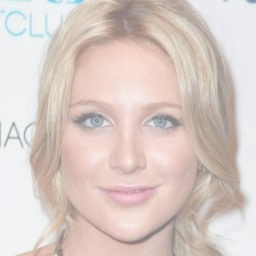

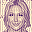

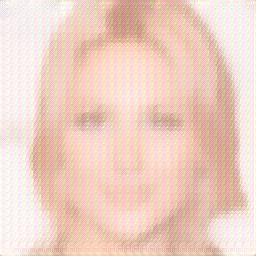

AssertionError: Latents are already present. Delete all latent files and rerun

In [65]:
# from sklearn.externals import joblib

def infer(args):
    with open(args.config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)
    dataset_config = config['dataset_params']
    autoencoder_config = config['autoencoder_params']
    train_config = config['train_params']
#     im_dataset_cls = {
#         'celebhq': ImageDataset,
#     }.get(dataset_config['name'])
    im_dataset = CelebDataset(split='train',
                                im_path='/kaggle/input/celebritydataset/celeba_hq_256',
                                im_size=dataset_config['im_size'],
                                im_channels=dataset_config['im_channels'])
    print(im_dataset)
    data_loader = DataLoader(im_dataset,
                            batch_size=1,
                            shuffle=False)
    print(data_loader)

    num_images = train_config['num_samples']
    ngrid = train_config['num_grid_rows']
    idxs = torch.randint(0, len(dataset) - 1, (num_images,))
    ims = torch.cat([dataset[idx][None, :] for idx in idxs]).float()
    ims = ims.to(device)
    model = VQVAE(im_channels=dataset_config['im_channels'],
                model_config=autoencoder_config).to(device)
    model.load_state_dict(torch.load("/kaggle/input/vqvae/pytorch/default/1/vqvae_autoencoder_ckpt (2).pth", map_location=device))
    
    model.eval()
    with torch.no_grad():
        encoded_output, _ = model.encode(ims)
        decoded_output = model.decode(encoded_output)
        encoded_output = torch.clamp(encoded_output, -1., 1.)
        encoded_output = (encoded_output + 1) / 2
        decoded_output = torch.clamp(decoded_output, -1., 1.)
        decoded_output = (decoded_output + 1) / 2
        ims = (ims + 1) / 2

        encoder_grid = make_grid(encoded_output.cpu(), nrow = ngrid)
        decoder_grid = make_grid(decoded_output.cpu(), nrow = ngrid)
        input_grid = make_grid(ims.cpu(), nrow = ngrid)
        encoder_grid = torchvision.transforms.ToPILImage()(encoder_grid)
        decoder_grid = torchvision.transforms.ToPILImage()(decoder_grid)
        input_grid = torchvision.transforms.ToPILImage()(input_grid)
        display(input_grid)
        display(encoder_grid)
        display(decoder_grid)
        input_grid.save(os.path.join('/kaggle/working/celebhq', 'input_samples.png'))
        encoder_grid.save(os.path.join('/kaggle/working/celebhq', 'encoded_samples.png'))
        decoder_grid.save(os.path.join('/kaggle/working/celebhq', 'reconstructed_samples.png'))
#         if train_config['save_latents']:
        if True:
            latent_path = os.path.join(train_config['task_name'], train_config['vqvae_latent_dir_name'])
            latent_fnames = glob.glob(os.path.join(train_config['task_name'], train_config['vqvae_latent_dir_name'], '*.pkl'))
            assert len(latent_fnames) == 0, "Latents are already present. Delete all latent files and rerun"
            if not os.path.exists(latent_path):
                os.mkdir(latent_path)
            print('Saving latents for {}'.format(dataset_config['name']))
            fname_latent_map = {}
            part_count = 0
            count = 0
            for idx, im in enumerate(tqdm(dataloader)):
                encoded_output, _ = model.encode(im.float().to(device))
                fname_latent_map[imss[idx]] = encoded_output.cpu()
                if(count + 1) % 1000 == 0:
                    pickle.dump(fname_latent_map, open(os.path.join(latent_path, '{}.pkl'.format(part_count)), 'wb'))
                    part_count += 1
                    fname_latent_map = {}
                count += 1
            if len(fname_latent_map) > 0:
                pickle.dum(fname_latent_map, open(os.path.join(latent_path, '{}.pkl'.format(part_count)), 'wb'))

            print('Done saving latents')

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description = 'Arguments for vqvae inference')
    parser.add_argument('--config', dest = 'config_path', default = '/kaggle/input/celebyaml/celebhq_text_cond (1).yaml', type = str)
    args = parser.parse_args(args = [])
    infer(args)


### **Train**

In [66]:
# Creating a custom dataset class 
class ImageDatasetNew(torch.utils.data.Dataset): 
    def __init__(self, im_size = 256, im_channels = 3, use_latents = False, latent_path = None, condition_config = None): 
        ims = []
        fnames = []
        texts = []
        fnames += glob.glob(os.path.join('/kaggle/input/textcond/image', 'images/*.jpg'))
        
        for fname in tqdm(fnames):
            ims.append(fname)
            im_name = os.path.split(fname)[1].split('.')[0]
            captions_im = []
            with open(os.path.join('/kaggle/input/textcond/text', 'celeba-caption/{}.txt'.format(im_name))) as f:
                for line in f.readlines():
                    captions_im.append(line.strip())
            texts.append(captions_im)
        assert len(texts) == len(ims), "Condition type text but could not find output for all images"
        self.images = ims
        self.texts = texts
        self.use_latents = use_latents
        if use_latents and latent_path is not None:
            latent_maps = load_latents(latent_path)
            if len(latent_maps) == len(self.images):
                self.use_latents = True
                self.latent_maps = latent_maps
                print('Found {} latents'.format(len(self.latent_maps)))
            else:
                print('Latents not found')
    
    def __getitem__(self, index):
        cond_inputs = {}
        cond_inputs['text'] = random.sample(self.texts[index], k = 1)[0]
        if self.use_latents:
            latent = self.latent_maps[self.images[index]]
            return latent, cond_inputs
        else:
            im = Image.open(self.images[index])
            im_tensor = torchvision.transforms.Compose([
                torchvision.transforms.Resize(self.im_size),
                torchvision.transforms.CenterCrop(self.im_size),
                torchvision.transforms.ToTensor()
            ])(im)
            im.close()
            im_tensor = (2 * im_tensor) - 1
            return im_tensor, cond_inputs
    def __len__(self):
        return len(self.images)

In [67]:
from torch.optim import Adam


In [68]:
def get_config_value(config, key, default_value):
    return config[key] if key in config else default_value

In [70]:
def trainFinal(args):
    with open(args.config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)

    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    diffusion_model_config = config['ldm_params']
    autoencoder_model_config = config['autoencoder_params']
    train_config = config['train_params']

    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])
#     im_dataset_cls = {
#         'celebhq': CelebDataset,
#     }.get(dataset_config['name'])

#     im_dataset = im_dataset_cls(split='train',
#                                 im_path=dataset_config['im_path'],
#                                 im_size=dataset_config['im_size'],
#                                 im_channels=dataset_config['im_channels'],
#                                 use_latents=True,
#                                 latent_path=os.path.join(train_config['task_name'], train_config['vqvae_latent_dir_name'])
#                                 )
#     data_loader = DataLoader(im_dataset,
#                              batch_size=train_config['ldm_batch_size'],
#                              shuffle=True)
    text_tokenizer = None
    text_model = None
    empty_text_embed = None
    condition_types = []
    condition_config = get_config_value(diffusion_model_config, key = 'condition_config', default_value = None)
    print("condition_config = ", condition_config)
    if condition_config is not None:
        assert 'condition_types' in condition_config, 'condition type missing in condition config'
        condition_types = condition_config['condition_types']
        if 'text' in condition_types:
            validate_text_config(condition_config)
            with torch.no_grad():
                text_tokenizer, text_model = get_tokenizer_and_model(condition_config['text_condition_config']['text_embed_model'], device = device)
                empty_text_embed = get_text_representation([''], text_tokenizer, text_model, device)
            
            
    im_dataset = ImageDatasetNew(use_latents = True, latent_path=os.path.join(train_config['task_name'],
                                                         train_config['vqvae_latent_dir_name']))
    dataloader = DataLoader(im_dataset, batch_size=1, shuffle=True)
    
    model = Unet(im_channels=autoencoder_model_config['z_channels'],
                 model_config=diffusion_model_config).to(device)
    model.train()
    vae = None
    if not im_dataset.use_latents:
        print('Loading vqvae model as latents not present')
        vae = VQVAE(im_channels=dataset_config['im_channels'],
                    model_config=autoencoder_model_config).to(device)
        vae.eval()
#     -------------
        if os.path.exists('/kaggle/input/vqvae/pytorch/default/1/vqvae_autoencoder_ckpt (2).pth'):
                print('Loaded vae checkpoint')
                vae.load_state_dict(torch.load('/kaggle/input/vqvae/pytorch/default/1/vqvae_autoencoder_ckpt (2).pth', map_location=device))
        else:
            raise Exception('VAE checkpoint not found and use_latents was disabled')

    num_epochs = 5
    optimizer = Adam(model.parameters(), lr = train_config['ldm_lr'])
    criterion = nn.MSELoss()

    if not im_dataset.use_latents:
        assert vae is not None
        for param in vae.parameters():
            param.requires_grad = False

    for epoch_idx in range(7):
        losses = []
        for data in tqdm(dataloader):
            cond_input = None
            if condition_config is not None:
                im, cond_input = data
            else:
                im = data
            optimizer.zero_grad()
            im = im.float().to(device)
            if not im_dataset.use_latents:
                with torch.no_grad():
                    im, _ = vae.encode(im)
            if 'text' in condition_types:
                with torch.no_grad():
                    assert 'text' in cond_input, 'conditioning type text but no text present'
                    validate_text_config(condition_config)
                    text_condition = get_text_representation(cond_input['text'], text_tokenizer, text_model, device)
                    text_drop_prob = get_config_value(condition_config['text_condition_config'], 'cond_drop_prob', 0.)
                    text_condition = drop_text_condition(text_condition, im, empty_text_embed, text_drop_prob)
                    cond_input['text'] = text_condition
            
            

            noise = torch.randn_like(im).to(device)
            t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)
            noisy_im = scheduler.add_noise(im, noise, t)
            noise_pred = model(noisy_im, t, cond_input = cond_input)

            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        print('Finished epoch: {} | Loss: {:.4f}'.format(epoch_idx + 1, np.mean(losses)))
        torch.save(model.state_dict(), os.path.join(train_config['task_name'], train_config['ldm_ckpt_name']))
    print("Done training")

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Arguments for ddpm training')
    parser.add_argument('--config', dest='config_path',
                        default='/kaggle/input/celebyaml/celebhq_text_cond (1).yaml', type=str)
    args = parser.parse_args(args = [])
    trainFinal(args)

{'dataset_params': {'im_path': '/kaggle/input/celebritydataset/celeba_hq_256', 'im_channels': 3, 'im_size': 256, 'name': 'celebhq'}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.00085, 'beta_end': 0.012}, 'ldm_params': {'down_channels': [256, 384, 512, 768], 'mid_channels': [768, 512], 'down_sample': [True, True, True], 'attn_down': [True, True, True], 'time_emb_dim': 512, 'norm_channels': 32, 'num_heads': 16, 'conv_out_channels': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'condition_config': {'condition_types': ['text'], 'text_condition_config': {'text_embed_model': 'clip', 'train_text_embed_model': False, 'text_embed_dim': 512, 'cond_drop_prob': 0.1}}}, 'autoencoder_params': {'z_channels': 3, 'codebook_size': 8192, 'down_channels': [64, 128, 256, 256], 'mid_channels': [256, 256], 'down_sample': [True, True, True], 'attn_down': [False, False, False], 'norm_channels': 32, 'num_heads': 4, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers':

100%|██████████| 30000/30000 [02:28<00:00, 201.48it/s]


Found 30000 latents


100%|██████████| 30000/30000 [49:41<00:00, 10.06it/s] 


Finished epoch: 1 | Loss: 0.0654


 20%|██        | 6076/30000 [10:00<39:09, 10.18it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 30000/30000 [49:38<00:00, 10.07it/s]


Finished epoch: 2 | Loss: 0.0466


100%|██████████| 30000/30000 [49:45<00:00, 10.05it/s] 


Finished epoch: 3 | Loss: 0.0433


100%|██████████| 30000/30000 [49:24<00:00, 10.12it/s] 


Finished epoch: 4 | Loss: 0.0419


100%|██████████| 30000/30000 [49:23<00:00, 10.12it/s] 


Finished epoch: 5 | Loss: 0.0411


100%|██████████| 30000/30000 [49:17<00:00, 10.15it/s] 


Finished epoch: 6 | Loss: 0.0404


100%|██████████| 30000/30000 [49:15<00:00, 10.15it/s] 


Finished epoch: 7 | Loss: 0.0396
Done training


### **Sample VQVAE and DDPM**

In [88]:
def sample(model, scheduler, train_config, diffusion_model_config, autoencoder_model_config, diffusion_config, dataset_config, vae, text_tokenizer, text_model):
    im_size = dataset_config['im_size'] // 2 ** sum(autoencoder_model_config['down_sample'])
    xt = torch.randn((1, autoencoder_model_config['z_channels'], im_size, im_size)).to(device)
    text_prompt = ['She is a woman with blond hair. She is wearing lipstick']
    neg_prompt = ['He is a man']
    empty_prompt = ['']
    text_prompt_embed = get_text_representation(text_prompt, text_tokenizer, text_model, device)
    empty_text_embed = get_text_representation(empty_prompt, text_tokenizer, text_model, device)
    assert empty_text_embed.shape == text_prompt_embed.shape
    
    uncond_input = {'text': empty_text_embed}
    cond_input = {'text': text_prompt_embed}
    cf_guidance_scale = get_config_value(train_config, 'cf_guidance_scale', 1.0)
    
    for i in tqdm(reversed(range(diffusion_config['num_timesteps']))):
        t = (torch.ones((xt.shape[0],)) * i).long().to(device)
        noise_pred_cond = model(xt, t, cond_input)
        
        if cf_guidance_scale > 1:
            noise_pred_uncond = model(xt, t, uncond_input)
            noise_pred = noise_pred_uncond + cf_guidance_scale * (noise_pred_cond - noise_pred_uncond)
        else:
            noise_pred = noise_pred_cond
        
        
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))
        if i == 0:
            ims = vae.decode(xt)
        else:
            ims = xt

        ims = torch.clamp(ims, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow = train_config['num_grid_rows'])
        img = torchvision.transforms.ToPILImage()(grid)

        if not os.path.exists(os.path.join(train_config['task_name'], 'samples')):
            os.mkdir(os.path.join(train_config['task_name'], 'samples'))
        img.save(os.path.join(train_config['task_name'], 'samples', 'x0_{}.png'.format(i)))
        img.close()


def infer(args):
    with open(args.config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)
    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    diffusion_model_config = config['ldm_params']
    autoencoder_model_config = config['autoencoder_params']
    train_config = config['train_params']
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                 beta_start=diffusion_config['beta_start'],
                                 beta_end=diffusion_config['beta_end'])
    text_tokenizer = None
    text_model = None
    
    condition_config = get_config_value(diffusion_model_config, key = 'condition_config', default_value = None)
    assert condition_config is not None, ("This sampling script is for text conditioning but no conditioning config found")
    condition_types = get_config_value(condition_config, 'condition_types', [])
    assert 'text' in condition_types, ("This sampling script is for text conditioning but no text conditioning found in config")
    validate_text_config(condition_config)
    
    with torch.no_grad():
        text_tokenizer, text_model = get_tokenizer_and_model(condition_config['text_condition_config']['text_embed_model'], device = device)

    model = Unet(im_channels=autoencoder_model_config['z_channels'],
                model_config=diffusion_model_config).to(device)
    model.eval()
    if os.path.exists(os.path.join(train_config['task_name'],
                                train_config['ldm_ckpt_name'])):
        print('Loaded unet checkpoint')
        model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                    train_config['ldm_ckpt_name']),
                                        map_location=device))
    else:
        raise Exception('Model checkpoint {} not found'.format(os.path.join(train_config['task_name'], train_config['ldm_ckpt_name'])))
        
    # Create output directories
    if not os.path.exists(train_config['task_name']):
        os.mkdir(train_config['task_name'])

    vae = VQVAE(im_channels=dataset_config['im_channels'],
                model_config=autoencoder_model_config).to(device)
    vae.eval()
    if os.path.exists('/kaggle/input/vqvae/pytorch/default/1/vqvae_autoencoder_ckpt (2).pth'):
        print('Loaded vae checkpoint')
        vae.load_state_dict(torch.load('/kaggle/input/vqvae/pytorch/default/1/vqvae_autoencoder_ckpt (2).pth', map_location=device))
    else:
        raise Exception('VAE checkpoint {} not found'.format(os.path.join(train_config['task_name'], train_config['vqvae_autoencoder_ckpt_name'])))
        
    with torch.no_grad():
        sample(model, scheduler, train_config, diffusion_model_config,
            autoencoder_model_config, diffusion_config, dataset_config, vae, text_tokenizer, text_model)


In [90]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Arguments for ddpm image generation')
    parser.add_argument('--config', dest='config_path',
                        default='/kaggle/input/celebyaml/celebhq_text_cond (1).yaml', type=str)
    args = parser.parse_args(args = [])
    print("OK")
    infer(args)

OK
{'dataset_params': {'im_path': '/kaggle/input/celebritydataset/celeba_hq_256', 'im_channels': 3, 'im_size': 256, 'name': 'celebhq'}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.00085, 'beta_end': 0.012}, 'ldm_params': {'down_channels': [256, 384, 512, 768], 'mid_channels': [768, 512], 'down_sample': [True, True, True], 'attn_down': [True, True, True], 'time_emb_dim': 512, 'norm_channels': 32, 'num_heads': 16, 'conv_out_channels': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'condition_config': {'condition_types': ['text'], 'text_condition_config': {'text_embed_model': 'clip', 'train_text_embed_model': False, 'text_embed_dim': 512, 'cond_drop_prob': 0.1}}}, 'autoencoder_params': {'z_channels': 3, 'codebook_size': 8192, 'down_channels': [64, 128, 256, 256], 'mid_channels': [256, 256], 'down_sample': [True, True, True], 'attn_down': [False, False, False], 'norm_channels': 32, 'num_heads': 4, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layer

1000it [00:27, 35.97it/s]


In [92]:
im = Image.open('/kaggle/working/celebhq/samples/x0_1.png')

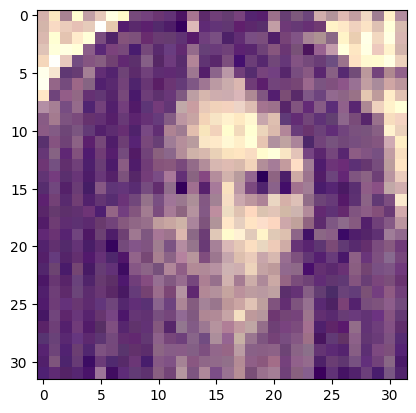

In [94]:
from matplotlib import pyplot as plt

plt.imshow(im)